In [1]:
using Pkg
pkg"activate ."
pkg"add Cbc"
pkg"add Clp"
pkg"add JuMP"
pkg"add Juniper"
pkg"add Ipopt"
pkg"add Plots"

Activating environment at `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Project.toml`
 [no changes]
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Project.toml`
 [no changes]
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Project.toml`
 [no changes]
  Updating `~/Documents/disciplinas/cmi043-cmm204-cm106/slides/aula-modelagem-jump/Manifest.toml`
 [no changes]
 Res

In [2]:
using Cbc, Clp, Juniper, JuMP, Ipopt

# Exemplo 1

- Alice e Bob trabalham fazendo colares e pulseiras de miçangas;
- Cada colar gasta 50 miçangas e cada pulseira gasta 30 miçangas;
- O custo do pacote com 100 miçangas é R\\$ 2;
- Uma análise preliminar indica que eles conseguem vender um colar a R\\$ 30 e uma pulseira a R\\$ 20;
- Cada um tem 40h de trabalho por semana;
- Cada colar gasta 4h e cada pulseira gasta 3h.

In [3]:
model = Model(with_optimizer(Clp.Optimizer))

@variable(model, num_colares ≥ 0)
@variable(model, num_pulseiras ≥ 0)

# Dinheiro
@objective(model, Max, 30 * num_colares + 20 * num_pulseiras - (2 / 100 * 50) * num_colares - (2 / 100 * 30) * num_pulseiras)

@constraint(model, 4 * num_colares + 3 * num_pulseiras ≤ 2 * 40)

println(model)
optimize!(model)

value(num_colares), value(num_pulseiras)

Max 29 num_colares + 19.4 num_pulseiras
Subject to
 4 num_colares + 3 num_pulseiras ≤ 80.0
 num_colares ≥ 0.0
 num_pulseiras ≥ 0.0

Coin0506I Presolve 0 (-1) rows, 0 (-2) columns and 0 (-2) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 580
Coin0511I After Postsolve, objective 580, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 580 - 0 iterations time 0.002, Presolve 0.00


(20.0, 0.0)

## Reescrevendo com índices

Conjuntos
- $P = \{\text{colar}, \text{pulseira}\}$: Conjunto de produtos

Parâmetros:
- $a$: custo da miçanga (em 100 de unidades);
- $T_{\max}$: tempo disponível;
- $v_p$: preço de venda do produto $p \in P$;
- $M_p$: quantidade de miçanga utilizada pelo produto $p \in P$;
- $T_p$: quantidade de tempo para produzir o produto $p \in P$;

Variáveis
- $x_p$: quantidade do produto $p \in P$;

\begin{align}
\max \qquad & \sum_p v_p x_p - \sum_p \frac{a}{100} M_p x_p \\
\text{s.to} \qquad & \sum_p T_p x_p \leq T_{\max} \\
& x_p \geq 0
\end{align}

In [4]:
P = ["colar", "pulseira"]
np = length(P)

a = 2.0
Tmax = 2 * 40
v = [30.0; 20.0]
M = [50; 30]
T = [4.0; 3.0]

model = Model(with_optimizer(Clp.Optimizer))

@variable(model, x[1:np] ≥ 0)

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] - a * M[p] / 100 * x[p] for p = 1:np))

@constraint(model, sum(T[p] * x[p] for p = 1:np) ≤ Tmax)

println(model)

optimize!(model)

value.(x), objective_value(model)

Max 29 x[1] + 19.4 x[2]
Subject to
 4 x[1] + 3 x[2] ≤ 80.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0

Coin0506I Presolve 0 (-1) rows, 0 (-2) columns and 0 (-2) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 580
Coin0511I After Postsolve, objective 580, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 580 - 0 iterations time 0.002, Presolve 0.00


([20.0, 0.0], 580.0)

## Matricialmente

\begin{align}
\max \qquad & v^T x - \frac{a}{100} M^T x \\
\text{s.to} \qquad & T^T x \leq T_{\max} \\
& x_p \geq 0
\end{align}

In [5]:
using LinearAlgebra

P = ["colar", "pulseira"]
np = length(P)

a = 2.0
Tmax = 2 * 40
v = [30.0; 20.0]
M = [50; 30]
T = [4.0; 3.0]

model = Model(with_optimizer(Clp.Optimizer))

@variable(model, x[1:np] ≥ 0)

# Dinheiro
@objective(model, Max, dot(v, x) - a / 100 * dot(M, x))

@constraint(model, dot(T, x) ≤ Tmax)

println(model)

optimize!(model)

value.(x), objective_value(model)

Max 29 x[1] + 19.4 x[2]
Subject to
 4 x[1] + 3 x[2] ≤ 80.0
 x[1] ≥ 0.0
 x[2] ≥ 0.0

Coin0506I Presolve 0 (-1) rows, 0 (-2) columns and 0 (-2) elements
Clp3002W Empty problem - 0 rows, 0 columns and 0 elements
Clp0000I Optimal - objective value 580
Coin0511I After Postsolve, objective 580, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 580 - 0 iterations time 0.002, Presolve 0.00


([20.0, 0.0], 580.0)

# Exemplo 2

Além de tudo do exemplo 1, também temos
- Cada colar usa 120 cm de fio, e cada pulseira use 30 cm de fio;
- A quantidade de miçangas e fio atualmente disponíveis é 3 pacotes e 1.2m;
- O custo do rolo de 1 metro de fio é R\$ 4.5;
- 

Conjuntos
- $P = \{\text{colar}, \text{pulseira}\}$: Conjunto de produtos
- $M = \{\text{rolo de fio}, \text{pacote de miçanga}\}$: Conjunto de materiais

Parâmetros:
- $a_m$: custo do material $m \in M$;
- $T_{\max}$: tempo disponível;
- $v_p$: preço de venda do produto $p \in P$;
- $T_p$: quantidade de tempo para produzir o produto $p \in P$;
- $Q_m$: quantidade inicial do material $m \in M$;
- $U_{m,p}$: quantidade de material $m \in M$ utilizada pelo produto $p \in P$;

Variáveis
- $x_p$: quantidade do produto $p \in P$ vendida;
- $y_m$: quantidade do material $m \in M$ comprada.

**Atenção:** devemos converter as unidades para aquelas do conjunto $M$, isto é, um colar usa 0.5 pacotes de miçanga e 0.25 rolos de fio e uma pulseira usa $0.3$ pacotes de miçanga e 0.2 rolos de fio.

\begin{align}
\max \qquad & \sum_p v_p x_p - \sum_m a_m y_m \\
\text{s.to} \qquad & \sum_p T_p x_p \leq T_{\max} \\
& \sum_p U_{m,p} x_p \leq Q_m + y_m \quad \forall m \in M \\
& x_p, y_m \geq 0
\end{align}

In [6]:
P = ["colar", "pulseira"]
M = ["rolo de fio", "pacote de miçanga"]
np = length(P)
nm = length(M)

a = [2.0; 4.5]
Tmax = 2 * 40
v = [30.0; 20.0]
Q = [3.0; 1.2]
U = [0.5  0.3;
     1.2  0.3]
T = [4.0; 3.0]

model = Model(with_optimizer(Clp.Optimizer))

@variable(model, x[1:np] ≥ 0)
@variable(model, y[1:nm] ≥ 0)

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] for p = 1:np) - sum(a[m] * y[m] for m = 1:nm))

@constraint(model, sum(T[p] * x[p] for p = 1:np) ≤ Tmax)
@constraint(model, [m=1:nm], sum(U[m,p] * x[p] for p = 1:np) ≤ Q[m] + y[m])

println(model)

optimize!(model)

value.(x), value.(y), objective_value(model)

Max 30 x[1] + 20 x[2] - 2 y[1] - 4.5 y[2]
Subject to
 4 x[1] + 3 x[2] ≤ 80.0
 0.5 x[1] + 0.3 x[2] - y[1] ≤ 3.0
 1.2 x[1] + 0.3 x[2] - y[2] ≤ 1.2
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 y[1] ≥ 0.0
 y[2] ≥ 0.0

Coin0506I Presolve 2 (-1) rows, 3 (-1) columns and 4 (-4) elements
Clp0006I 0  Obj 560.05 Primal inf 25.971748 (2)
Clp0006I 2  Obj 492.73333
Clp0000I Optimal - objective value 492.73333
Coin0511I After Postsolve, objective 492.73333, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 492.7333333 - 2 iterations time 0.002, Presolve 0.00


([0.0, 26.666666666666668], [5.0, 6.800000000000004], 492.73333333333335)

# Exemplo 3

O mesmo, mas os valores são inteiros

In [7]:
P = ["colar", "pulseira"]
M = ["rolo de fio", "pacote de miçanga"]
np = length(P)
nm = length(M)

a = [2.0; 4.5]
Tmax = 2 * 40
v = [30.0; 20.0]
Q = [3.0; 1.2]
U = [0.5  0.3;
     1.2  0.3]
T = [4.0; 3.0]

model = Model(with_optimizer(Cbc.Optimizer))

@variable(model, x[1:np] ≥ 0, Int)
@variable(model, y[1:nm] ≥ 0, Int)

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] for p = 1:np) - sum(a[m] * y[m] for m = 1:nm))

@constraint(model, sum(T[p] * x[p] for p = 1:np) ≤ Tmax)
@constraint(model, [m=1:nm], sum(U[m,p] * x[p] for p = 1:np) ≤ Q[m] + y[m])

println(model)

optimize!(model)

value.(x), value.(y), objective_value(model)

Max 30 x[1] + 20 x[2] - 2 y[1] - 4.5 y[2]
Subject to
 4 x[1] + 3 x[2] ≤ 80.0
 0.5 x[1] + 0.3 x[2] - y[1] ≤ 3.0
 1.2 x[1] + 0.3 x[2] - y[2] ≤ 1.2
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 y[1] ≥ 0.0
 y[2] ≥ 0.0
 x[1] integer
 x[2] integer
 y[1] integer
 y[2] integer

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 492.733 - 0.00 seconds
Cgl0003I 0 fixed, 2 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 3 rows, 4 columns (4 integer (0 of which binary)) and 8 elements
Cbc0012I Integer solution of -472 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0038I Full problem 3 rows 4 columns, reduced to 0 rows 0 columns
Cbc0012I Integer solution of -478.5 found by RINS after 0 iterations and 0 nodes (0.00 seconds)
Cbc0012I Integer solution of -488.5 found by DiveCoefficient after 12 iterations and 0 nodes (0.00 seconds)
Cbc0031I 3 

([5.0, 20.0], [6.0, 11.000000000000002], 488.5)

# Exemplo 4

Depois de algumas semanas trabalhando nessa estratégia, Alice e Bob têm o seguinte insight:
- Muitas vezes não vendem todas as pulseiras, mas se dão um desconto nas finais, conseguem levar alguma a mais;
- Muitas vezes vendem todos os colares da semana e pessoas comprariam mais.

Uma possibilidade de modelar essa diferença é considerando uma demanda ajustável. Eles descobrem que a demanda para as pulseiras é 15, e que se derem desconto de 30% no valor, eles vendem o resto das pulseiras.

Outra possibilidade seria considerar baixar o preço das pulseiras para aumentar a demanda.

## Estratégia 1

Conjuntos
- $P = \{\text{colar}, \text{pulseira}\}$: Conjunto de produtos
- $M = \{\text{rolo de fio}, \text{pacote de miçanga}\}$: Conjunto de materiais

Parâmetros:
- $a_m$: custo do material $m \in M$;
- $T_{\max}$: tempo disponível;
- $v_p$: preço de venda do produto $p \in P$;
- $T_p$: quantidade de tempo para produzir o produto $p \in P$;
- $Q_m$: quantidade inicial do material $m \in M$;
- $U_{m,p}$: quantidade de material $m \in M$ utilizada pelo produto $p \in P$;
- $D_p$: demanda pelo produto $p \in P$ com o preço original;
- $v_p^+$: novo preço do produto $p \in P$ tal que todos os produtos além da demanda sejam vendidos.

Variáveis
- $x_p$: quantidade do produto $p \in P$ vendida até a demanda;
- $x_p^+$: quantidade do produto $p \in P$ vendida além da demanda;
- $y_m$: quantidade do material $m \in M$ comprada.

\begin{align}
\max \qquad & \sum_p v_p x_p + \sum_p v_p^+ x_p^+ - \sum_m a_m y_m \\
\text{s.to} \qquad & \sum_p T_p (x_p + x_p^+) \leq T_{\max} \\
& \sum_p U_{m,p} (x_p + x_p^+) \leq Q_m + y_m \quad \forall m \in M \\
& 0 \leq x_p \leq D_p, \quad p \in P \\
& x_p^+, y_m \geq 0
\end{align}

In [8]:
P = ["colar", "pulseira"]
M = ["rolo de fio", "pacote de miçanga"]
np = length(P)
nm = length(M)

a = [2.0; 4.5]
Tmax = 2 * 40
v = [30.0; 20.0]
v⁺ = [20.0; 14.0]
Q = [3.0; 1.2]
U = [0.5  0.3;
     1.2  0.3]
T = [4.0; 3.0]
D = [6; 15]

model = Model(with_optimizer(Cbc.Optimizer))

@variable(model, 0 ≤ x[p = 1:np] ≤ D[p], Int)
@variable(model, x⁺[1:np] ≥ 0, Int)
@variable(model, y[1:nm] ≥ 0, Int)

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] + v⁺[p] * x⁺[p] for p = 1:np) - sum(a[m] * y[m] for m = 1:nm))

@constraint(model, sum(T[p] * (x[p] + x⁺[p]) for p = 1:np) ≤ Tmax)
@constraint(model, [m=1:nm], sum(U[m,p] * (x[p] + x⁺[p]) for p = 1:np) ≤ Q[m] + y[m])

println(model)

optimize!(model)

value.(x), value.(x⁺), value.(y), objective_value(model)

Max 30 x[1] + 20 x⁺[1] + 20 x[2] + 14 x⁺[2] - 2 y[1] - 4.5 y[2]
Subject to
 4 x[1] + 4 x⁺[1] + 3 x[2] + 3 x⁺[2] ≤ 80.0
 0.5 x[1] + 0.5 x⁺[1] + 0.3 x[2] + 0.3 x⁺[2] - y[1] ≤ 3.0
 1.2 x[1] + 1.2 x⁺[1] + 0.3 x[2] + 0.3 x⁺[2] - y[2] ≤ 1.2
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 x⁺[1] ≥ 0.0
 x⁺[2] ≥ 0.0
 y[1] ≥ 0.0
 y[2] ≥ 0.0
 x[1] ≤ 6.0
 x[2] ≤ 15.0
 x[1] integer
 x[2] integer
 x⁺[1] integer
 x⁺[2] integer
 y[1] integer
 y[2] integer

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Oct  7 2019 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 467.933 - 0.00 seconds
Cgl0003I 0 fixed, 2 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 3 rows, 6 columns (6 integer (0 of which binary)) and 14 elements
Cbc0012I Integer solution of -456 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seconds)
Cbc0038I Full problem 3 rows 6 columns, reduced to 0 rows 0 columns
Cbc0012I Integer solution of -459 found by 

([6.0, 15.0], [2.0, 1.0], [6.0, 14.000000000000002], 459.0)

## Estratégia 2

A estratégia 2 tenta estabelecer que a demanda depende do preço, e daí o preço do produto também é uma variável a ser decidida.
- Uma escolha tradicional de curva de demanda é algo do tipo $d = \alpha + \beta p$, com $\beta < 0$.
- Considerando que nos preços de R\\$ 30 e R\\$ 20 a demanda foi 6 e 15 resp., temos 
\begin{align}
\alpha_{\text{colar}} + 30\beta_{\text{colar}} & = 6 \\
\alpha_{\text{pulseira}} + 20\beta_{\text{pulseira}} & = 15
\end{align}
- Precisamos de pelo menos mais um dado para estimar nossa demanda, então podemos considerar que o valor máximo que alguém pagaria pelo colar ou pulseira é R\\$ 70 e R\\$ 45. Dessa maneira temos também
\begin{align}
\alpha_{\text{colar}} + 70\beta_{\text{colar}} & = 1 \\
\alpha_{\text{pulseira}} + 45\beta_{\text{pulseira}} & = 1
\end{align}

Conjuntos
- $P = \{\text{colar}, \text{pulseira}\}$: Conjunto de produtos
- $M = \{\text{rolo de fio}, \text{pacote de miçanga}\}$: Conjunto de materiais

Parâmetros:
- $a_m$: custo do material $m \in M$;
- $T_{\max}$: tempo disponível;
- $T_p$: quantidade de tempo para produzir o produto $p \in P$;
- $Q_m$: quantidade inicial do material $m \in M$;
- $U_{m,p}$: quantidade de material $m \in M$ utilizada pelo produto $p \in P$;
- $\alpha_p, \beta_p$: constantes usadas na definição da demanda do produto $p \in P$: $d_p = \alpha_p + \beta_p v_p$.

Variáveis
- $x_p$: quantidade do produto $p \in P$ vendida;
- $y_m$: quantidade do material $m \in M$ comprada.
- $v_p$: preço de venda do produto $p \in P$;

Expressões (usadas para simplificar a escrita)
- $d_p = \alpha_p + \beta_p v_p$: demanda para $p \in P$.

\begin{align}
\max \qquad & \sum_p v_p x_p - \sum_m a_m y_m \\
\text{s.to} \qquad & \sum_p T_p x_p \leq T_{\max} \\
& \sum_p U_{m,p} x_p \leq Q_m + y_m \quad \forall m \in M \\
& x_p \leq d_p \quad \forall p \in P \\
& d_p = \alpha_p + \beta_p v_p \quad \forall p \in P \\
& d_p, x_p, y_m, v_p \geq 0
\end{align}

**Atenção**: Esse problema agora é não linear.

In [9]:
P = ["colar", "pulseira"]
M = ["rolo de fio", "pacote de miçanga"]
np = length(P)
nm = length(M)

a = [2.0; 4.5]
Tmax = 2 * 40
Q = [3.0; 1.2]
U = [0.5  0.3;
     1.2  0.3]
T = [4.0; 3.0]

αβ = [1 0 30 0;
      0 1  0 20;
      1 0 70 0;
      0 1  0 45] \ [6; 15; 1; 1]
α = αβ[1:2]
β = αβ[3:4]

model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

@variable(model, x[1:np] ≥ 0)
@variable(model, y[1:nm] ≥ 0)
@variable(model, v[1:np] ≥ 0)

@expression(model, d[p=1:np], α[p] + β[p] * v[p])

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] for p = 1:np) - sum(a[m] * y[m] for m = 1:nm))

@constraint(model, sum(T[p] * x[p] for p = 1:np) ≤ Tmax)
@constraint(model, [m=1:nm], sum(U[m,p] * x[p] for p = 1:np) ≤ Q[m] + y[m])
@constraint(model, [p=1:np], x[p] ≤ d[p])
@constraint(model, [p=1:np], d[p] ≥ 0)

println(model)

optimize!(model)

value.(x), value.(y), value.(v), objective_value(model)

Max v[1]*x[1] + v[2]*x[2] - 2 y[1] - 4.5 y[2]
Subject to
 -0.125 v[1] ≥ -9.75
 -0.56 v[2] ≥ -26.200000000000003
 4 x[1] + 3 x[2] ≤ 80.0
 0.5 x[1] + 0.3 x[2] - y[1] ≤ 3.0
 1.2 x[1] + 0.3 x[2] - y[2] ≤ 1.2
 x[1] + 0.125 v[1] ≤ 9.75
 x[2] + 0.56 v[2] ≤ 26.200000000000003
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 y[1] ≥ 0.0
 y[2] ≥ 0.0
 v[1] ≥ 0.0
 v[2] ≥ 0.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([4.475000048779446, 12.554000131014975], [3.003700034946885, 7.936200086396673], [42.20000038920445, 24.367857376559368], 453.03878803938426)

In [10]:
using Juniper

P = ["colar", "pulseira"]
M = ["rolo de fio", "pacote de miçanga"]
np = length(P)
nm = length(M)

a = [2.0; 4.5]
Tmax = 2 * 40
Q = [3.0; 1.2]
U = [0.5  0.3;
     1.2  0.3]
T = [4.0; 3.0]

αβ = [1 0 30 0;
      0 1  0 20;
      1 0 70 0;
      0 1  0 45] \ [6; 15; 1; 1]
α = αβ[1:2]
β = αβ[3:4]

optimizer = Juniper.Optimizer
params = Dict{Symbol,Any}()
params[:nl_solver] = with_optimizer(Ipopt.Optimizer, print_level=0)
model = Model(with_optimizer(optimizer, params))

@variable(model, x[1:np] ≥ 0, Int)
@variable(model, y[1:nm] ≥ 0, Int)
@variable(model, v[1:np] ≥ 0)

@expression(model, d[p=1:np], α[p] + β[p] * v[p])

# Dinheiro
@objective(model, Max, sum(v[p] * x[p] for p = 1:np) - sum(a[m] * y[m] for m = 1:nm))

@constraint(model, sum(T[p] * x[p] for p = 1:np) ≤ Tmax)
@constraint(model, [m=1:nm], sum(U[m,p] * x[p] for p = 1:np) ≤ Q[m] + y[m])
@constraint(model, [p=1:np], x[p] ≤ d[p])
@constraint(model, [p=1:np], d[p] ≥ 0)

println(model)

optimize!(model)

value.(x), value.(y), value.(v), objective_value(model)

Max v[1]*x[1] + v[2]*x[2] - 2 y[1] - 4.5 y[2]
Subject to
 -0.125 v[1] ≥ -9.75
 -0.56 v[2] ≥ -26.200000000000003
 4 x[1] + 3 x[2] ≤ 80.0
 0.5 x[1] + 0.3 x[2] - y[1] ≤ 3.0
 1.2 x[1] + 0.3 x[2] - y[2] ≤ 1.2
 x[1] + 0.125 v[1] ≤ 9.75
 x[2] + 0.56 v[2] ≤ 26.200000000000003
 x[1] ≥ 0.0
 x[2] ≥ 0.0
 y[1] ≥ 0.0
 y[2] ≥ 0.0
 v[1] ≥ 0.0
 v[2] ≥ 0.0
 x[1] integer
 x[2] integer
 y[1] integer
 y[2] integer



┌ Info: no explicit NLP constraints or objective provided using @NLconstraint or @NLobjective macros
└ @ Juniper /home/abel/.julia/packages/Juniper/9MMco/src/MOI_wrapper/MOI_wrapper.jl:319


nl_solver         : OptimizerFactory(Ipopt.Optimizer, (), Base.Iterators.Pairs(:print_level => 0))
feasibility_pump  : false
log_levels        : Symbol[:Options, :Table, :Info]

#Variables: 6
#IntBinVar: 4
#Constraints: 7
#Linear Constraints: 7
#Quadratic Constraints: 0
#NonLinear Constraints: 0
Obj Sense: Max

Incumbent using start values: 0.0
Status of relaxation: LOCALLY_SOLVED
Time for relaxation: 2.099163055419922
Relaxation Obj: 453.03878803938426

 ONodes   CLevel          Incumbent                   BestBound            Gap    Time   Restarts  GainGap  
    2       2                0.0                        453.04            Inf%    1.5       0         -     
    3       3                0.0                        451.23            Inf%    2.1       -       73.4%   
    4       3                0.0                        450.83            Inf%    2.1       -       81.0%   
    5       4                0.0                        449.23            Inf%    2.2       -       72.5%

([4.0, 13.0], [3.0, 8.0], [46.0000004602922, 23.571428811618475], 448.4285816516883)

# Exemplo 5

Regressão logística

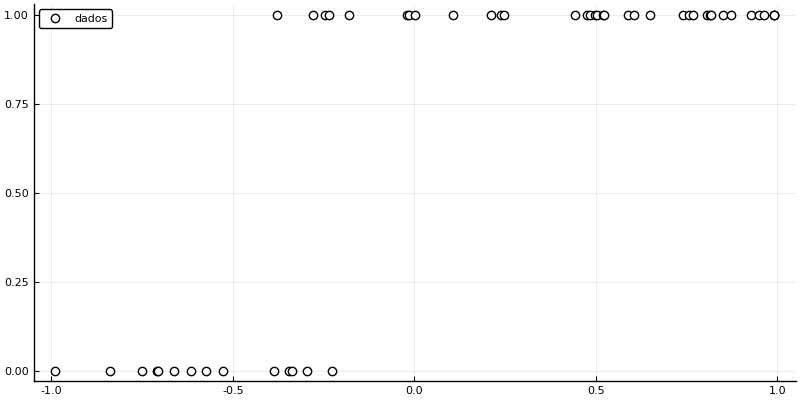

In [11]:
using Plots
pyplot()

n = 50
x = sort(rand(n) * 2 .- 1)
y = [xi + 0.2 + randn() * 0.25 > 0 ? 1.0 : 0.0 for xi in x]

scatter(x, y, m=(:white,6), size=(800,400), lab="dados")

$$ h(x; \beta) = \sigma(\beta_0 + \beta_1 x) = \frac{1}{1 + e^{-\beta_0 - \beta_1 x}} $$

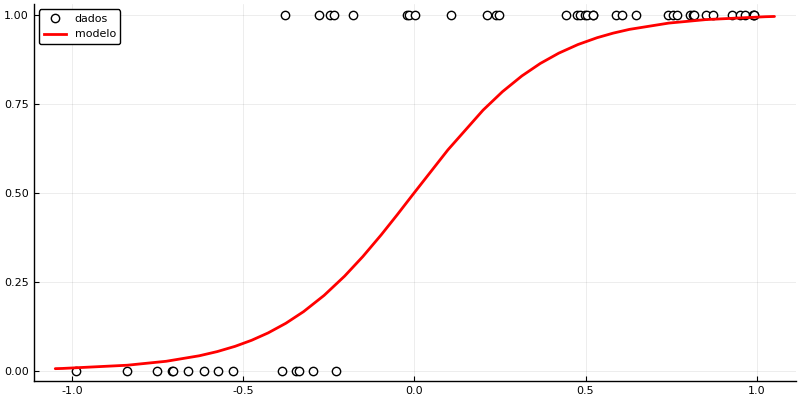

In [12]:
scatter(x, y, m=(:white,6), size=(800,400), lab="dados")
σ(t) = 1 / (1 + exp(-t))
h(x, β) = σ(β[1] + β[2] * x)
plot!(x -> h(x, [0.0; 5.0]), c=:red, lw=2, lab="modelo")

**Função de verossimilhança**

$$ L(\beta) = \prod_i h(x_i,\beta)^{y_i} (1 - h(x_i,\beta))^{1 - y_i} $$

**Função de log-verossimilhança**

$$ \ell(\beta) = \sum_i y_i \ln h(x_i,\beta) + (1 - y_i) \ln(1 - h(x_i,\beta)) $$

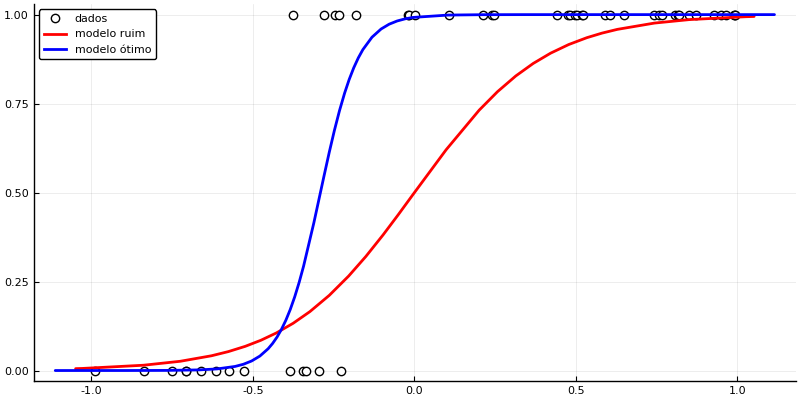

In [13]:
using JuMP, Ipopt

model = Model(with_optimizer(Ipopt.Optimizer, print_level=1))

@variable(model, β[1:2])

@NLexpression(model, hi[i = 1:n], 1 / (1 + exp(-β[1] - β[2] * x[i])))
@NLobjective(model, Max, sum(y[i] * log(hi[i]) + (1 - y[i]) * log(1 - hi[i]) for i = 1:n))

optimize!(model)

β = value.(β)

scatter(x, y, m=(:white,6), size=(800,400), lab="dados")
plot!(x -> h(x, [0.0; 5.0]), c=:red, lw=2, lab="modelo ruim")
plot!(x -> h(x, β), c=:blue, lw=2, lab="modelo ótimo")

# Exemplo 6

Menor círculo que comporta vários circulos

https://en.wikipedia.org/wiki/Circle_packing_in_a_circle

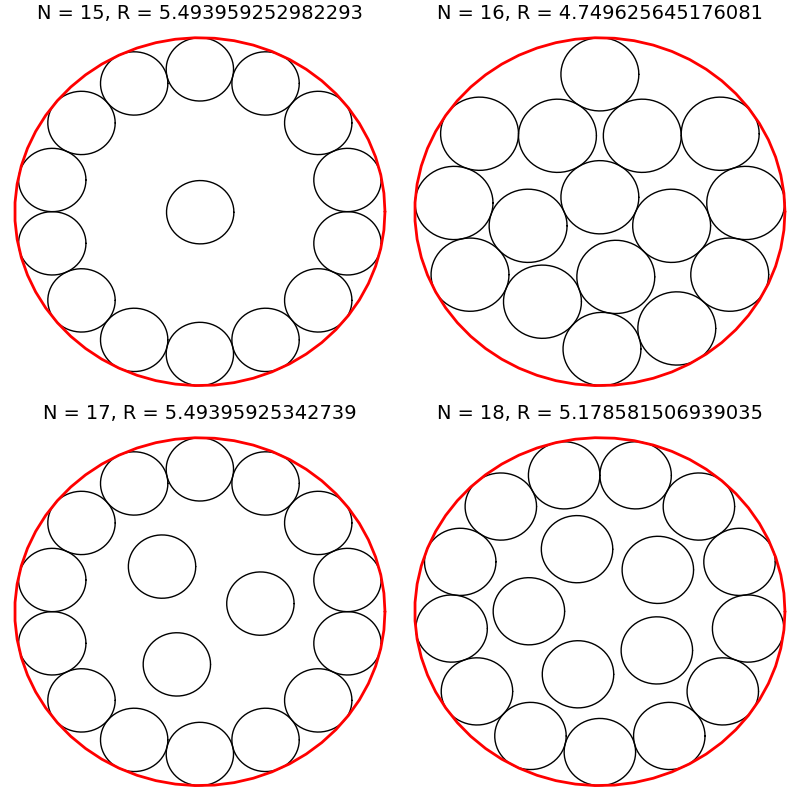

In [14]:
using JuMP, Ipopt

p = plot(leg=false, grid=false, axis=false, size=(800,800), layout=@layout [a b; c d])
k = 1
r = 1.0
for N = 15:18
    model = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

    @variable(model, x[i=1:N], start=(2r + randn()) * cos(2π * rand()))
    @variable(model, y[i=1:N], start=(2r + randn()) * sin(2π * rand()))
    @variable(model, R ≥ r)

    @constraint(model, x[1] == 0) # Sempre posso girar o círculo

    @objective(model, Min, R)

    @constraint(model, [i=1:N], x[i]^2 + y[i]^2 ≤ (R - r)^2) # √xᵢ² + yᵢ² + r ≤ R
    @constraint(model, [i=1:N,j=i+1:N], (x[i] - x[j])^2 + (y[i] - y[j])^2 ≥ 4r^2) # √(xᵢ-xⱼ)² + (yᵢ-yⱼ)² ≥ 2r

    optimize!(model)

    x = value.(x)
    y = value.(y)
    R = value(R)
 
    θ = range(0, 2π, length=60)
    c, s = cos.(θ), sin.(θ)
    for i = 1:N
        plot!(p[k], x[i] .+ r * c, y[i] .+ r * s, c=:black)
    end
    plot!(p[k], R * c, R * s, c=:red, lw=2)
    title!(p[k], "N = $N, R = $R")
    k += 1
end
plot!()